<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Прогнозирование-заказов-такси" data-toc-modified-id="Прогнозирование-заказов-такси-1">Прогнозирование заказов такси</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2">Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3">Анализ</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4">Обучение моделей</a></span></li><li><span><a href="#Тестирование-наилучшей-модели" data-toc-modified-id="Тестирование-наилучшей-модели-5">Тестирование наилучшей модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6">Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('C:/Users/datasets/taxi.csv') 
except:
    data = pd.read_csv('//datasets/taxi.csv') 

*Изучим общую информацию*

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


*Изменим тип данных с object на datetime64*

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])

*Установите индекс таблицы равным столбцу datetime.*

In [6]:
data = data.set_index('datetime')

*Проверим, в хронологическом ли порядке расположены даты и время.*

In [7]:
data.index.is_monotonic

True

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Признак даты сделали индексом, тем самым преобразовали датафрейм во временной ряд 👍
</div>

# Анализ

*Выполним ресемплирование по одному часу и просуммируем заказы такси.*

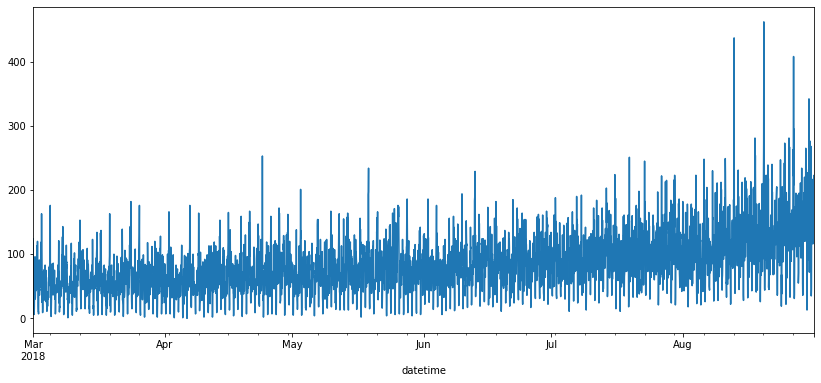

In [8]:
data = data.resample('1H').sum()
data.plot(figsize=(14,6), legend=False);

*Воспользуемся декомпозицией и разложим временной ряд на три составляющие: тренд, сезонность и остаток.*

In [9]:
decomposed = seasonal_decompose(data)

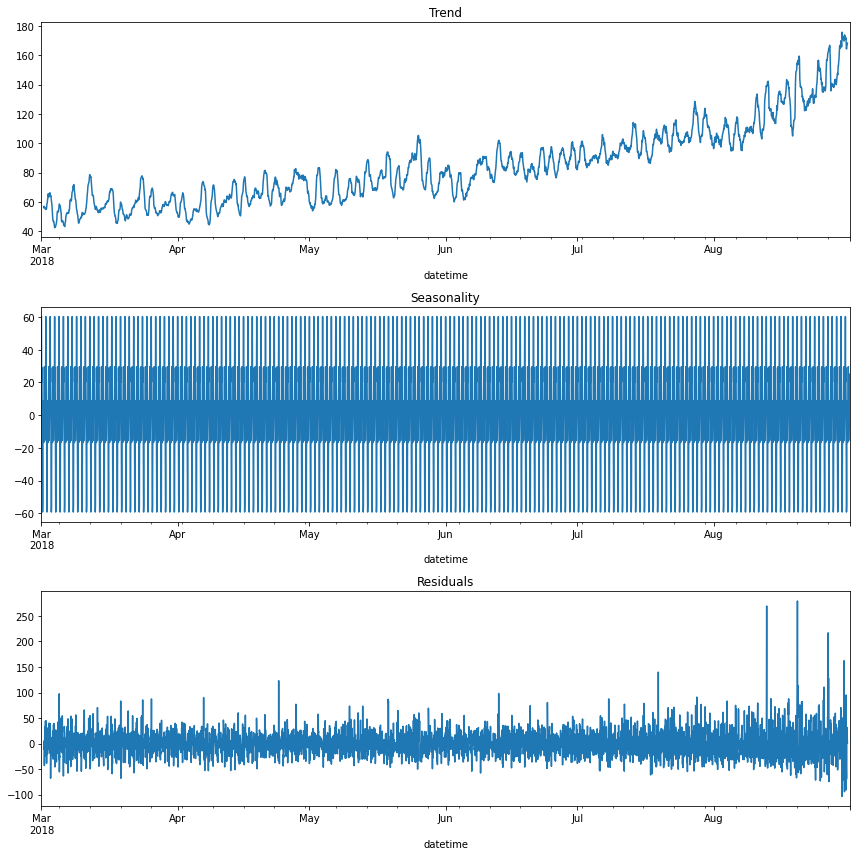

In [10]:
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

На графике "Trend"  мы можем наблюдать увеличение количества заказов. Из чего мы можем сделать вывод, что временной ряд не является стационарным.

# Обучение моделей

*Напишем функцию которая создаст новые признаки.*

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Подберём значения в цикле для max_lag и rolling_mean_size на примере линейной регрессии.

In [12]:
%%time

df = data.copy() 
best_rmse = 48
best_w = 0
best_k = 0
values = [i for i in range(1, 26)]
for w in values:
    for k in values:
        make_features(df, w, k)
        
        data_train, data_test = train_test_split(df, shuffle=False, test_size=0.1) 
        data_train.dropna(inplace=True)
        
        x_train = data_train.drop('num_orders', axis=1)
        y_train = data_train['num_orders']
        x_test = data_test.drop('num_orders', axis=1)
        y_test = data_test['num_orders']
        
        tscv = TimeSeriesSplit(n_splits=5)  
    
        model = LinearRegression()
        rmse_lr = ((-cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_mean_squared_error'))**0.5).mean()
        
        if rmse_lr < best_rmse:
            best_rmse = rmse_lr
            best_w = w
            best_k = k
            
print('RMSE:', best_rmse, '\nmax_lag:', best_w, '\nRolling_mean_size:', best_k)

RMSE: 27.007382703073027 
max_lag: 25 
Rolling_mean_size: 22
CPU times: user 1min 39s, sys: 3min 46s, total: 5min 25s
Wall time: 5min 26s


*Запустим созданную нами функцию со значениями max_lag и rolling_mean_size.*

In [13]:
make_features(data, best_w, best_k)


*Разделим данные на обучающую и тестовую выборки*

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

*Признаки и целевой признак*

In [15]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

*RandomForest*

In [16]:
%%time

params_grid = {'max_depth': range(2, 10),
              'n_estimators': range(1, 35, 10)}
model = RandomForestRegressor(random_state=12345)
search = GridSearchCV(model, params_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(train_features, train_target)

print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

RMSE: 26.736254212652693 при значениях гиперпараметров: {'max_depth': 9, 'n_estimators': 31}
CPU times: user 34.7 s, sys: 0 ns, total: 34.7 s
Wall time: 34.9 s


*CatBoostRegressor*

In [17]:
%%time

params_grid = {'learning_rate': [x/10 for x in range(1, 6)]}
model = CatBoostRegressor(random_state=12345, verbose=False)
search = GridSearchCV(model, params_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(train_features, train_target)

print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

RMSE: 25.274508796296427 при значениях гиперпараметров: {'learning_rate': 0.1}
CPU times: user 2min 30s, sys: 3.74 s, total: 2min 34s
Wall time: 3min 4s


*LGBMRegressor*

In [18]:
params_grid = {'learning_rate': [x/10 for x in range(1, 6)]}

model = LGBMRegressor(random_state=12345)
search = GridSearchCV(model, params_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(train_features, train_target)

print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

RMSE: 25.89595494489954 при значениях гиперпараметров: {'learning_rate': 0.1}


In [25]:
results = [[27.00], [26.73], [25.27], [25.89]]
models = ['LinearRegression', 'RandomForest','CatBoost', 'LightGBM']

pd.DataFrame(data=results, index=models, columns=['RMSE_train'])

,RMSE_train
LinearRegression,27.00
RandomForest,26.73
CatBoost,25.27
LightGBM,25.89


# Тестирование наилучшей модели

RMSE: 41.25496882112546
CPU times: user 7.72 s, sys: 134 ms, total: 7.85 s
Wall time: 9.37 s


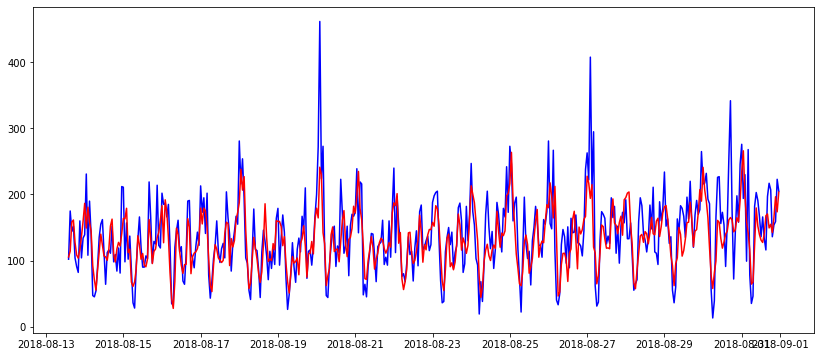

In [22]:
%%time

model = CatBoostRegressor(learning_rate=0.1, random_state=12345, verbose=False)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
print('RMSE:', mean_squared_error(test_target, target_predict) ** 0.5)

plt.figure(figsize=(14,6))
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-');

# Вывод

Наилучший результат показала модель CatBoost - 41.25496882112546